In [1]:
import pytorch_influence_functions as ptif
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm

In [2]:
DEVICE: str = 'cpu'
print(f'Using {DEVICE} device')

Using cpu device


### Load Dataset

In [3]:
iris = load_iris()

In [4]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


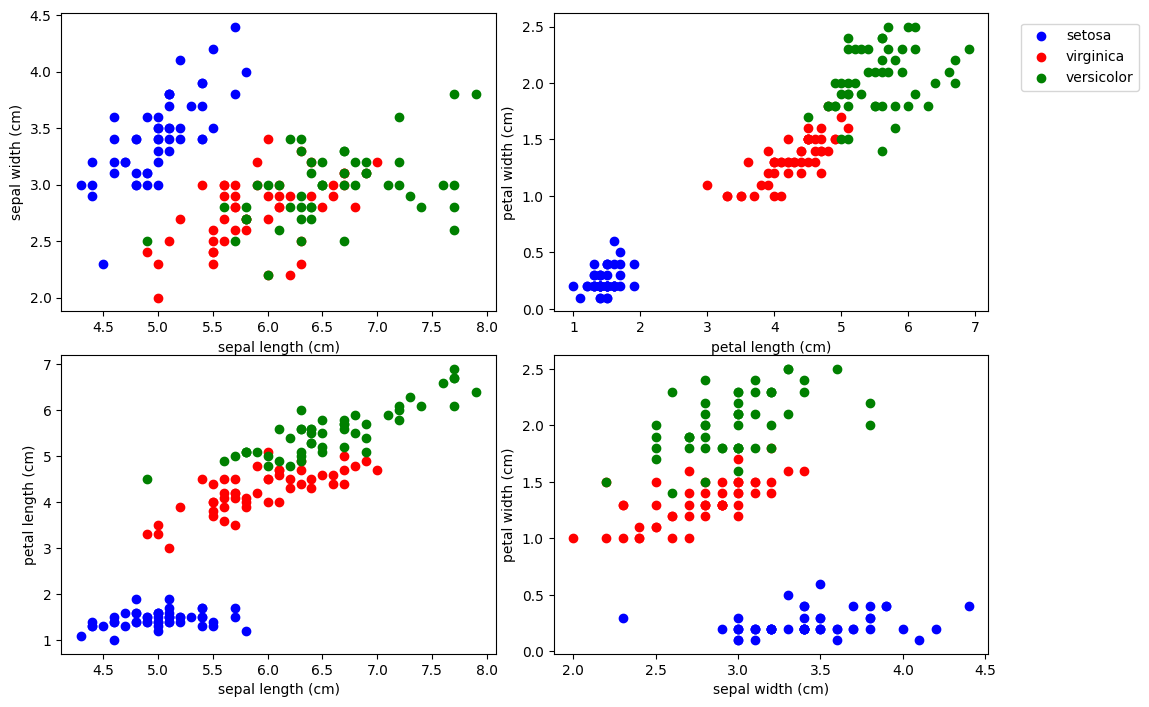

In [5]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(10,7))
fig.tight_layout()

plots = [(0, 1), (2,3), (0,2), (1,3)]
colors = ['blue', 'red', 'green']
labels = ['setosa', 'virginica', 'versicolor']

for i, ax in enumerate(axes.flat):
  for j in range(3):
    x = df.columns[plots[i][0]]
    y = df.columns[plots[i][1]]
    ax.scatter(df[df['target'] == j][x], df[df['target'] == j][y], color = colors[j])
    ax.set(xlabel=x, ylabel=y)
    
fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0, 0.85))
plt.show()

### Prepare Dataset

In [6]:
from torch.utils.data import TensorDataset, DataLoader


# split into train-test sets
train_X, test_X, train_y, test_y = train_test_split(df.drop('target',axis=1).values,
                                                    df['target'].values, test_size=0.2,
                                                    random_state=33)

In [7]:
class IrisDataset(Dataset):
  def __init__(self, feats, labels):
    self.feats = torch.tensor(feats, dtype=torch.float)
    self.labels = torch.tensor(labels, dtype=torch.long)
    
  def __len__(self):
    return self.feats.shape[0]
  
  def __getitem__(self, index):
    feat = self.feats[index]
    label = self.labels[index]
    return feat, label

In [8]:
iris_train = IrisDataset(train_X, train_y)
iris_test = IrisDataset(test_X, test_y)

batch_size = 32
train_loader = DataLoader(iris_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(iris_test, batch_size=batch_size, shuffle=True)

In [9]:
class ANN(nn.Module):
  
  def __init__(self, in_dim, hidden_dims, out_dim):
    # determine the number of layers
    super(ANN, self).__init__()
    self.in_dim = in_dim
    
    # this is a list containing the required hidden dim size(s)
    self.hidden_dims = hidden_dims
    self.out_dim = out_dim
    
    # input layer
    self.in_layer = nn.Linear(in_dim, hidden_dims[0])
    
    # hidden layer(s)
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims) -1):
      self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
      
    # output layer
    self.out_layer = nn.Linear(hidden_dims[-1], out_dim)
      
  
  def forward(self, x):
    x = F.relu(self.in_layer(x))
    for layer in self.hidden_layers:
      x = F.relu(layer(x))
    x = self.out_layer(x)
    return x

In [10]:
def train_model(model, train_loader, test_loader, num_epochs, DEVICE):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  
  #device = 'cuda' if torch.cuda.is_available() else 'cpu'
 
  train_losses = np.zeros(num_epochs)
  test_losses = np.zeros(num_epochs) 
  
  for epoch in range(num_epochs):
    train_loss = []
    total_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
    
    for input, target in progress_bar:
      # move data to GPU
      input, target = input.to(DEVICE), target.to(DEVICE)
      optimizer.zero_grad()
      y_pred = model.forward(input)
      loss = criterion(y_pred, target)
      
      # backprop
      loss.backward()
      optimizer.step()
      
      total_loss +=  loss.item()
      train_loss.append(loss.item())
      progress_bar.set_postfix({'loss': total_loss / len(train_loader)})
      
    # get avg. train loss for batch
    train_loss = np.mean(train_loss)
    
    test_loss = []
    for input, target in test_loader:
      input, target = input.to(DEVICE), target.to(DEVICE)
      y_pred = model(input)
      loss = criterion(y_pred, target)
      test_loss.append(loss.item())
    
    # get avg. test loss for batch
    test_loss = np.mean(test_loss)
    
    # save losses 
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    
    
    #print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {total_loss / len(train_loader)}')
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    

In [11]:
in_dim = 4

# should have at least as many neurons as feats
hidden_dims = [8, 9]
out_dim = 3

model = ANN(in_dim=in_dim, hidden_dims=hidden_dims, out_dim=out_dim)

In [12]:
train_model(model, train_loader, test_loader, 100, DEVICE)

Epoch 1/100, Train Loss: 1.0862, Test Loss: 1.0932


Epoch 2/100, Train Loss: 1.0309, Test Loss: 1.0102


Epoch 3/100, Train Loss: 0.9625, Test Loss: 0.9243


Epoch 4/100, Train Loss: 0.8919, Test Loss: 0.8404


Epoch 5/100, Train Loss: 0.7913, Test Loss: 0.7596


Epoch 6/100, Train Loss: 0.7100, Test Loss: 0.6793


Epoch 7/100, Train Loss: 0.6105, Test Loss: 0.5973


Epoch 8/100, Train Loss: 0.5279, Test Loss: 0.5308


Epoch 9/100, Train Loss: 0.4648, Test Loss: 0.4702


Epoch 10/100, Train Loss: 0.4142, Test Loss: 0.4128


Epoch 11/100, Train Loss: 0.3654, Test Loss: 0.4079


Epoch 12/100, Train Loss: 0.3259, Test Loss: 0.3403


Epoch 13/100, Train Loss: 0.2984, Test Loss: 0.2999


Epoch 14/100, Train Loss: 0.2564, Test Loss: 0.3350


Epoch 15/100, Train Loss: 0.2386, Test Loss: 0.2412


Epoch 16/100, Train Loss: 0.2149, Test Loss: 0.2454


Epoch 17/100, Train Loss: 0.2045, Test Loss: 0.2105


Epoch 18/100, Train Loss: 0.1705, Test Loss: 0.1726


Epoch 19/100, Train Loss: 0.1600, Test Loss: 0.1879


Epoch 20/100, Train Loss: 0.1495, Test Loss: 0.1754


Epoch 21/100, Train Loss: 0.1583, Test Loss: 0.1530


Epoch 22/100, Train Loss: 0.1249, Test Loss: 0.1167


Epoch 23/100, Train Loss: 0.1233, Test Loss: 0.1674


Epoch 24/100, Train Loss: 0.1500, Test Loss: 0.1395


Epoch 25/100, Train Loss: 0.1261, Test Loss: 0.0963


Epoch 26/100, Train Loss: 0.1161, Test Loss: 0.1644


Epoch 27/100, Train Loss: 0.1293, Test Loss: 0.1603


Epoch 28/100, Train Loss: 0.0984, Test Loss: 0.0826


Epoch 29/100, Train Loss: 0.1161, Test Loss: 0.1252


Epoch 30/100, Train Loss: 0.1057, Test Loss: 0.1424


Epoch 31/100, Train Loss: 0.1011, Test Loss: 0.0781


Epoch 32/100, Train Loss: 0.0980, Test Loss: 0.1168


Epoch 33/100, Train Loss: 0.0874, Test Loss: 0.0840


Epoch 34/100, Train Loss: 0.1058, Test Loss: 0.0743


Epoch 35/100, Train Loss: 0.0870, Test Loss: 0.1465


Epoch 36/100, Train Loss: 0.0893, Test Loss: 0.0798


Epoch 37/100, Train Loss: 0.0836, Test Loss: 0.0801


Epoch 38/100, Train Loss: 0.0864, Test Loss: 0.0977


Epoch 39/100, Train Loss: 0.0935, Test Loss: 0.0643


Epoch 40/100, Train Loss: 0.0959, Test Loss: 0.1489


Epoch 41/100, Train Loss: 0.0913, Test Loss: 0.0592


Epoch 42/100, Train Loss: 0.0786, Test Loss: 0.0864


Epoch 43/100, Train Loss: 0.0812, Test Loss: 0.1026


Epoch 44/100, Train Loss: 0.0767, Test Loss: 0.0568


Epoch 45/100, Train Loss: 0.0888, Test Loss: 0.0739


Epoch 46/100, Train Loss: 0.0769, Test Loss: 0.1361


Epoch 47/100, Train Loss: 0.0998, Test Loss: 0.0533


Epoch 48/100, Train Loss: 0.0713, Test Loss: 0.0998


Epoch 49/100, Train Loss: 0.0730, Test Loss: 0.0795


Epoch 50/100, Train Loss: 0.0728, Test Loss: 0.0604


Epoch 51/100, Train Loss: 0.0759, Test Loss: 0.0539


Epoch 52/100, Train Loss: 0.0733, Test Loss: 0.1011


Epoch 53/100, Train Loss: 0.0717, Test Loss: 0.0619


Epoch 54/100, Train Loss: 0.0773, Test Loss: 0.0523


Epoch 55/100, Train Loss: 0.0775, Test Loss: 0.0907


Epoch 56/100, Train Loss: 0.0741, Test Loss: 0.0525


Epoch 57/100, Train Loss: 0.0723, Test Loss: 0.0730


Epoch 58/100, Train Loss: 0.0748, Test Loss: 0.0590


Epoch 59/100, Train Loss: 0.0680, Test Loss: 0.0497


Epoch 60/100, Train Loss: 0.0678, Test Loss: 0.0781


Epoch 61/100, Train Loss: 0.0729, Test Loss: 0.0761


Epoch 62/100, Train Loss: 0.0728, Test Loss: 0.0347


Epoch 63/100, Train Loss: 0.0747, Test Loss: 0.0910


Epoch 64/100, Train Loss: 0.1064, Test Loss: 0.0687


Epoch 65/100, Train Loss: 0.1072, Test Loss: 0.0323


Epoch 66/100, Train Loss: 0.0879, Test Loss: 0.1683


Epoch 67/100, Train Loss: 0.0926, Test Loss: 0.0614


Epoch 68/100, Train Loss: 0.0842, Test Loss: 0.0306


Epoch 69/100, Train Loss: 0.0677, Test Loss: 0.1084


Epoch 70/100, Train Loss: 0.1063, Test Loss: 0.0935


Epoch 71/100, Train Loss: 0.0920, Test Loss: 0.0298


Epoch 72/100, Train Loss: 0.0871, Test Loss: 0.1104


Epoch 73/100, Train Loss: 0.0686, Test Loss: 0.0494


Epoch 74/100, Train Loss: 0.0629, Test Loss: 0.0574


Epoch 75/100, Train Loss: 0.0601, Test Loss: 0.0638


Epoch 76/100, Train Loss: 0.0691, Test Loss: 0.0528


Epoch 77/100, Train Loss: 0.0641, Test Loss: 0.0647


Epoch 78/100, Train Loss: 0.0753, Test Loss: 0.0896


Epoch 79/100, Train Loss: 0.0616, Test Loss: 0.0361


Epoch 80/100, Train Loss: 0.0651, Test Loss: 0.0526


Epoch 81/100, Train Loss: 0.0625, Test Loss: 0.0702


Epoch 82/100, Train Loss: 0.0642, Test Loss: 0.0560


Epoch 83/100, Train Loss: 0.0698, Test Loss: 0.0541


Epoch 84/100, Train Loss: 0.0662, Test Loss: 0.0766


Epoch 85/100, Train Loss: 0.0711, Test Loss: 0.0414


Epoch 86/100, Train Loss: 0.0642, Test Loss: 0.0642


Epoch 87/100, Train Loss: 0.0672, Test Loss: 0.0622


Epoch 88/100, Train Loss: 0.0584, Test Loss: 0.0351


Epoch 89/100, Train Loss: 0.0685, Test Loss: 0.0444


Epoch 90/100, Train Loss: 0.0674, Test Loss: 0.0934


Epoch 91/100, Train Loss: 0.0581, Test Loss: 0.0367


Epoch 92/100, Train Loss: 0.0874, Test Loss: 0.0316


Epoch 93/100, Train Loss: 0.0597, Test Loss: 0.1243


Epoch 94/100, Train Loss: 0.0693, Test Loss: 0.0491


Epoch 95/100, Train Loss: 0.0673, Test Loss: 0.0317


Epoch 96/100, Train Loss: 0.0584, Test Loss: 0.0720


Epoch 97/100, Train Loss: 0.0701, Test Loss: 0.0592


Epoch 98/100, Train Loss: 0.0611, Test Loss: 0.0619


Epoch 99/100, Train Loss: 0.0561, Test Loss: 0.0391


Epoch 100/100, Train Loss: 0.0666, Test Loss: 0.0517


### Validate Model

In [13]:
def validate_model(train_loader, test_loader, model):
  train_total = 0.
  train_num_correct = 0.
  with torch.no_grad():
    for input, target in train_loader:
      # get prediction
      y_pred = model(input)
      # get the max over the columns, returns (value, index)
      _, predicted_target = torch.max(y_pred.data, 1)
      train_num_correct += (predicted_target == target).sum().item()
      train_total += target.shape[0]
    print(f'Got {train_num_correct}/{train_total} correct on train set.')
    train_acc = 100*train_num_correct/train_total
    
  # validate on test set
  test_total = 0.
  test_num_correct = 0.
  with torch.no_grad():
    for input, target in test_loader:
      # get prediction
      y_pred = model(input)
      # get the max over the columns, returns (value, index)
      _, predicted_target = torch.max(y_pred.data, 1)
      test_num_correct += (predicted_target == target).sum().item()
      test_total += target.shape[0]
    print(f'Got {test_num_correct}/{test_total} correct on test set.')
    test_acc = 100*test_num_correct/test_total
    
  print(f'Train accuracy: {train_acc:.2f}%, Test accuracy: {test_acc:.2f}%')
  

In [14]:
validate_model(train_loader, test_loader, model)

Got 118.0/120.0 correct on train set.
Got 30.0/30.0 correct on test set.
Train accuracy: 98.33%, Test accuracy: 100.00%


In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, targets,
                          normalize=False):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  print(cm)
  
  plt.imshow(cm,  interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  tick_marks = np.arange(len(targets))
  plt.xticks(tick_marks, targets, rotation=45)
  plt.yticks(tick_marks, targets)
  
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]). range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment='center',
             color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Target')
    plt.xlabel('Predicted Target')
    plt.show()

### Compute Influences

In [16]:
ptif.init_logging()

config = ptif.get_default_config()
my_config: dict[str,any] = ptif.get_default_config()
my_config['gpu'] = -1 
my_config['num_classes'] = 3

print(my_config)

hi = ptif.calc_img_wise(my_config, model, train_loader, test_loader)

{'outdir': 'outdir', 'seed': 42, 'gpu': -1, 'dataset': 'CIFAR10', 'num_classes': 3, 'test_sample_num': 1, 'test_start_index': 0, 'recursion_depth': 1, 'r_averaging': 1, 'scale': None, 'damp': None, 'calc_method': 'img_wise', 'log_filename': None}
2024-04-11 22:09:23,950: Running on: 1 images per class.
2024-04-11 22:09:23,951: Starting at img number: 0 per class.


/home/shen/Projects/influence-functions/.venv/lib/python3.10/site-packages/pytorch_influence_functions-0.1.2-py3.10.egg/pytorch_influence_functions/influence_function.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Calc. s_test recursions: [=================================================] 1 / 1
Averaging r-times: [=======================================================] 1 / 1
Calc. influence function: [============================================] 119 / 120120
Calc. influence function: [============================================] 120 / 120
Calc. s_test recursions: [=================================================] 1 / 1/ 3
Averaging r-times: [=======================================================] 1 / 1
Calc. influence function: [============================================] 119 / 120120
Calc. influence function: [============================================] 120 / 120
Test samples processed: [=================================.................] 2 / 3
Calc. s_test recursions: [=================================================] 1 / 1
Averaging r-times: [=======================================================] 1 / 1
Calc. influence function: [============================================] 119 /

In [17]:
print(hi)

{'0': {'label': tensor(1), 'num_in_dataset': 0, 'time_calc_influence_s': 0.13071322441101074, 'influence': [0.0004733662062790245, 0.0004082288942299783, -0.0006183040095493197, -4.016778984805569e-05, -2.945149208244402e-05, -0.00031326941098086536, -0.0006372414063662291, 3.086245487793349e-05, -4.841516420128755e-05, 4.152918791078264e-06, 0.0019381806487217546, 7.211542106233537e-05, 7.118946086848155e-05, 3.40651354235888e-06, 3.5381408451939933e-06, -0.00018571170221548527, 2.8740753350575687e-06, -0.02157251350581646, 2.137498086085543e-06, 2.0128659343754407e-06, -1.0894442311837338e-05, -0.006505115423351526, 4.375394837552449e-06, 4.568293661577627e-05, -4.41912779933773e-05, -1.1671014362946153e-05, 0.0006319282692857087, 0.03061407245695591, 1.2735093832816347e-06, 2.3454922484233975e-05, -0.056784678250551224, 7.681667739234399e-06, 1.4942015695851296e-06, -0.03923230245709419, 0.0004481604846660048, 0.030084041878581047, -0.0004884309601038694, -0.0007228737231343985, -3.

In [18]:
print(hi.keys())

dict_keys(['0', '1', '2'])


In [19]:
print(hi['0'].keys())

dict_keys(['label', 'num_in_dataset', 'time_calc_influence_s', 'influence', 'harmful', 'helpful'])


In [25]:
print(hi['0']['helpful'])

[95, 52, 27, 35, 108, 100, 117, 78, 10, 76, 74, 75, 42, 43, 80, 26, 0, 34, 1, 113, 97, 55, 96, 47, 72, 73, 11, 12, 99, 105, 70, 23, 45, 98, 40, 7, 90, 29, 56, 84, 31, 111, 107, 88, 79, 77, 71, 22, 49, 53, 9, 64, 14, 13, 16, 110, 69, 94, 18, 59, 119, 19, 60, 51, 32, 85, 41, 28, 44, 67, 82, 93, 101, 83, 63, 109, 62, 92, 20, 25, 89, 54, 106, 50, 118, 102, 4, 38, 48, 3, 81, 24, 8, 115, 39, 68, 15, 114, 104, 5, 36, 86, 2, 6, 112, 87, 37, 61, 91, 116, 66, 65, 103, 21, 58, 57, 17, 46, 33, 30]
